In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma (
    embedding_function=embedding_function,
    collection_name='spring_framework_docs',
    persist_directory='./spring_framework_docs'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [3]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

graph_builder = StateGraph(AgentState)

In [4]:
def retrieve(state: AgentState):
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [6]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull("rlm/rag-prompt")
generate_llm = ChatOpenAI(model='gpt-4o', max_completion_tokens=100)

def generate(state: AgentState):
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | generate_llm # | StrOutputParser
    response = rag_chain.invoke({'question': query, 'context': context})
    return {'answer': response.content}

In [7]:
from langchain import hub
from typing import Literal
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
    query = state['query']
    context = state['context']
    print(f'context = {context}')
    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})
    print(f'doc relevance response: {response}')
    if response['Score'] == 1:
        return 'relevant'
    return 'irrelevant'

In [ ]:
from langchain_core.prompts import PromptTemplate

rewrite_prompt = PromptTemplate.from_template("""
사용자의 질문을 보고, 웹 검색에 용이하게 사용자의 질문을 수정해주세요.
질문: {query}
""")

# 입력된 쿼리(query)를 변형(rewrite)하여 새로운 쿼리를 생성하는 것
def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm
    response = rewrite_chain.invoke({'query': query})
    print('rewrite question == {response}')
    return {'query': response.content}

In [ ]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

def web_search(state: AgentState):
    query = state['query']
    results = tavily_search_tool.invoke(query)
    print('web search results == {results}')
    return {'context': results}

In [10]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)

graph_builder.add_node('web_search', web_search)

In [11]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance, {
        'relevant': 'generate',
        'irrelevant': 'rewrite'
    }
)
graph_builder.add_edge('rewrite', 'web_search')
graph_builder.add_edge('web_search', 'generate')
graph_builder.add_edge('generate', END)

In [12]:
graph = graph_builder.compile()

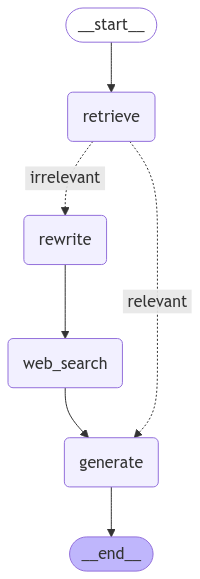

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
initial_state = {'query': '스프링 프레임워크에서 사용되는 통신규약은 무엇인가요?'}
graph.invoke(initial_state)

context = [Document(id='f9ac33c1-53ed-471c-a54c-0f782bddd224', metadata={'source': './documents/spring_framework_docs.txt'}, page_content='스프링 프레임워크 종합 안내서\n본 문서는 스프링 프레임워크의 기본 개념, 아키텍처, 주요 기능 및 최신 동향을 포함하여 총 10 페이지에 걸쳐 상세하게 설명합니다.\n서론\n1. 개요\n스프링 프레임워크는 자바 플랫폼을 위한 오픈 소스 애플리케이션 프레임워크로, 엔터프라이즈급 애플리케이션 개발을 위한 다양한 기능과 유연한 아키텍처를 제공합니다.\n\n역사: 2002년 로드 존슨(Rod Johnson)의 “Expert One-on-One J2EE Design and Development”를 시작으로 등장하였으며, 이후 경량 컨테이너와 객체 지향 프로그래밍 기법을 도입하여 급속히 확산되었습니다.\n목적: 복잡한 엔터프라이즈 애플리케이션 개발 시 발생하는 결합도 문제를 해소하고, 모듈화 및 재사용성을 높여 개발 생산성을 극대화하는 데 있습니다.\n\n2. 스프링의 필요성\n\n유연성: 전통적인 J2EE 기반의 복잡한 설정과 구현을 단순화합니다.\n모듈성: IoC/DI, AOP 등 모듈화를 통해 유저보수를 쉽게 합니다.\n확장성: 다양한 서브 모듈(웹, 데이터베이스 접근, 보안 등)을 제공하여 복합적인 요구 사항을 충족합니다.\n\n참고: Soonggi Tistory\n핵심 원칙 – IoC 와 DI\n1. 제어의 역전(IoC, Inversion of Control)\n\n개념: 객체의 생성과 의존관계 설정을 개발자가 아닌 스프링 컨테이너가 관리하는 방식입니다.\n장점: 결합도를 낮추어 코드의 재사용성과 테스트 용이성을 높입니다.\n\n2. 의존성 주입(DI, Dependency Injection)\n\n정의: 객체가 필요한 의존성을 스프링 컨테이너가 주입해 주는 방식입니다.\n구현 방식: XML 설정, 애노테이션(@Aut

{'query': '스프링 프레임워크에서 사용되는 통신 규약 종류',
 'context': [{'url': 'https://corner-ds.tistory.com/346',
   'content': '스프링 프레임워크에서 제공하는 클래스인 (UriComponentsBuilder)는 여러 파라미터를 연결하여 URI 형식으로 만드는 기능을 수행하며, RestTemplate를 생성할 때 사용한다. 5. HTTPClient의 종류에 따라 기능에 차이가 있으며, 가장 큰 차이는 (커넥션 풀)이다.'},
  {'url': 'https://scienceismagic.tistory.com/58',
   'content': '스프링 프레임워크(Spring Framework) 개요스프링 프레임워크(Spring Framework)는 자바 기반의 애플리케이션 개발을 위한 포괄적인 프레임워크입니다. 이 프레임워크는 엔터프라이즈 애플리케이션 개발에 필요한 다양한 기능을 제공하며, 특히 객체 지향 프로그래밍(OOP)의 원칙을 따르는 경량 솔루션을 지원'},
  {'url': 'https://intrepidgeeks.com/tutorial/advantages-disadvantages-and-characteristics-of-spring-frame',
   'content': '스프링 프레임워크의 특징을 설명하고, 장점 및 단점을 포스팅합니다. ... 문제점들을 정리해서 상황에 따라 간편하게 적용해서 쓸 수 있는 것을 정리하여 특정한 "규약"을 통해 쉽게 쓸 수 있는 형태로 만든 것을 말한다. ... (90종류 이상) 제공 · 인터넷 통신'}],
 'answer': '스프링 프레임워크에서 사용되는 주요 통신 규약은 HTTP입니다. RestTemplate와 같은 클래스는 주로 HTTP 프로토콜을 사용하여 통신합니다.'}